Importamos los paquetes necesarios:

In [1]:
import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import xskillscore as xs

Hemos almacenado los datos que vamos a utilizar en este notebook en nuestro Cloud para que todos podáis descargarlos y ejecutar este notebook.

Descargamos los datos:

In [2]:
!wget https://cloud.predictia.es/s/b53dPYnYFFqRG49/download

--2021-11-05 23:48:38--  https://cloud.predictia.es/s/b53dPYnYFFqRG49/download
Resolving cloud.predictia.es (cloud.predictia.es)... 51.15.110.102
Connecting to cloud.predictia.es (cloud.predictia.es)|51.15.110.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219991430 (210M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 209,80M  47,4MB/s    in 5,3s    

2021-11-05 23:48:44 (39,5 MB/s) - ‘download’ saved [219991430/219991430]



Cambiamos el nombre de los datos descargados y descomprimimos el fichero (.zip):

In [3]:
!mv download cassini-predictia.zip

In [4]:
!unzip cassini-predictia.zip

Archive:  cassini-predictia.zip
   creating: cassini-predictia-data/
  inflating: cassini-predictia-data/1980.nc  
  inflating: cassini-predictia-data/1981.nc  
  inflating: cassini-predictia-data/1982.nc  
  inflating: cassini-predictia-data/1983.nc  
  inflating: cassini-predictia-data/1984.nc  
  inflating: cassini-predictia-data/1985.nc  
  inflating: cassini-predictia-data/1986.nc  
  inflating: cassini-predictia-data/1987.nc  
  inflating: cassini-predictia-data/1988.nc  
  inflating: cassini-predictia-data/1989.nc  
  inflating: cassini-predictia-data/1990.nc  
  inflating: cassini-predictia-data/1991.nc  
  inflating: cassini-predictia-data/1992.nc  
  inflating: cassini-predictia-data/1993.nc  
  inflating: cassini-predictia-data/1994.nc  
  inflating: cassini-predictia-data/1995.nc  
  inflating: cassini-predictia-data/1996.nc  
  inflating: cassini-predictia-data/1997.nc  
  inflating: cassini-predictia-data/1998.nc  
  inflating: cassini-predictia-data/1999.nc  
  inflating

In [5]:
!rm cassini-predictia.zip

Para el análisis de datos multidimensionales (espacio y tiempo), el paquete por excelencia es Xarray.

In [6]:
files = glob.glob('cassini-predictia-data/*.nc')

In [7]:
files.sort()

In [8]:
data = xr.open_mfdataset(files[:-5])

In [9]:
data.load()

<xarray.Dataset>
Dimensions:  (y: 432, x: 432, time: 432)
Coordinates:
  * y        (y) float32 5.388e+06 5.362e+06 5.338e+06 ... -5.362e+06 -5.388e+06
  * x        (x) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2015-12-01
    lon      (y, x) float64 -135.0 -135.1 -135.3 -135.4 ... 44.73 44.87 45.0
    lat      (y, x) float64 16.62 16.82 17.02 17.22 ... 17.22 17.02 16.82 16.62
Data variables:
    siconca  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    tas      (time, y, x) float32 296.6 296.5 296.5 296.4 ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

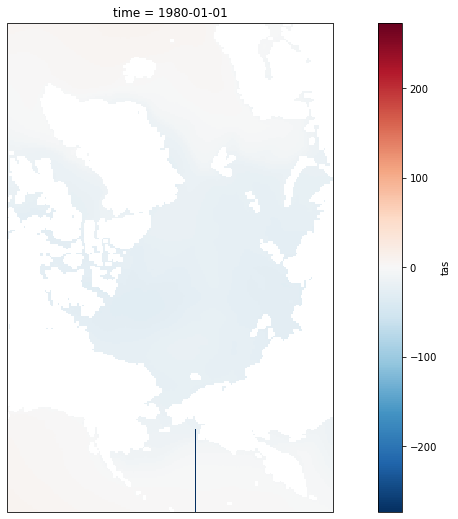

In [37]:
plt.figure(figsize=(16, 9))
def get_axes():
        projection = ccrs.NorthPolarStereo()
        ax = plt.axes(projection=projection)
        ax.coastlines(lw=1.5)
        return ax
ax = get_axes()
data.isel(time=0, x=slice(100, 300), y=slice(50, 350)).tas.plot(ax=ax)

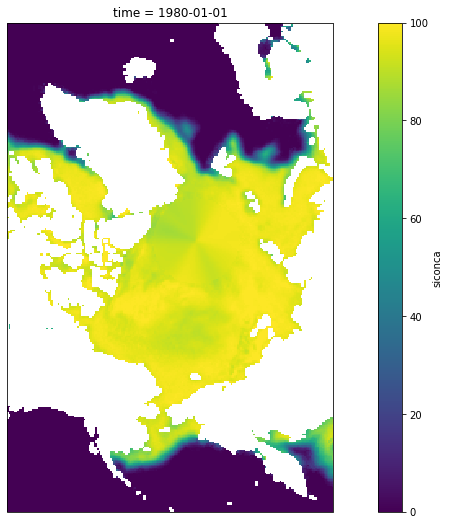

In [39]:
plt.figure(figsize=(16, 9))
def get_axes():
        projection = ccrs.NorthPolarStereo()
        ax = plt.axes(projection=projection)
        ax.coastlines(lw=1.5)
        return ax
ax = get_axes()
data.isel(time=0, x=slice(100, 300), y=slice(50, 350)).siconca.plot(ax=ax)

Transformamos los datos de:
temperatura -> K a ºC, concentración de hielo -> tanto por uno a tanto por ciento (%)

In [10]:
data['tas'] = data['tas'] - 273.15
data['siconca'] = data['siconca'] * 100

In [22]:
correlation = xs.pearson_r(
    data.resample(time='YS').mean().siconca, data.resample(time='YS').mean().tas,
    dim='time',
)

In [18]:
import numpy as np
np.all(np.isnan(correlation.values))

False

/home/pereza/miniconda3/envs/cassini-hackaton/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/pereza/miniconda3/envs/cassini-hackaton/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/pereza/miniconda3/envs/cassini-hackaton/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

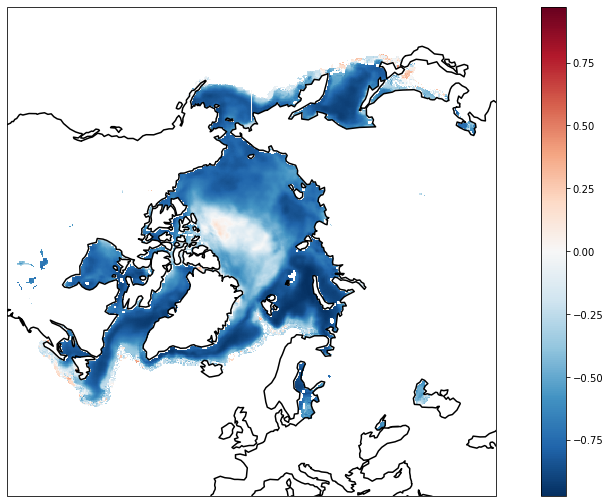

In [28]:
plt.figure(figsize=(16, 9))
def get_axes():
        projection = ccrs.LambertAzimuthalEqualArea(
            central_longitude=0, central_latitude=90
        )
        ax = plt.axes(projection=projection)
        ax.coastlines(lw=1.5)
        return ax
ax = get_axes()
correlation.plot(ax=ax)

In [24]:
correlation

<xarray.DataArray (y: 432, x: 432)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y        (y) float32 5.388e+06 5.362e+06 5.338e+06 ... -5.362e+06 -5.388e+06
  * x        (x) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
    lon      (y, x) float64 -135.0 -135.1 -135.3 -135.4 ... 44.73 44.87 45.0
    lat      (y, x) float64 16.62 16.82 17.02 17.22 ... 17.22 17.02 16.82 16.62